# Setting

If you want to create an environment, run the following commands step by step.

- Create a conda environment
    - conda create -n hyundai python=3.9
    - conda activate hyundai


- Install packages
    - pip install gymnasium matplotlib "gymnasium[toy-text]"

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print("numpy version", np.__version__)
print("gymnasium (gym) version", gym.__version__)
print("matplotlib version", matplotlib.__version__)

numpy version 2.0.2
gymnasium (gym) version 1.2.0
matplotlib version 3.10.0


# Environment

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array").unwrapped

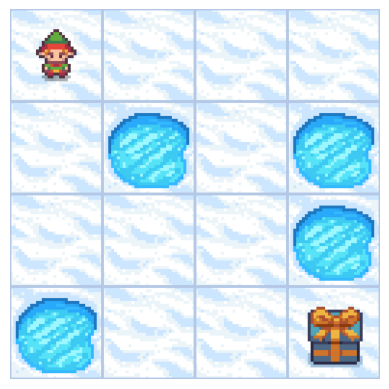

In [3]:
obs, info = env.reset(seed=1)
# Get Image
img = env.render()   # numpy array (H, W, 3)

plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
env.P[6][0]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 10, 0.0, False)]

- from state 6 and taking action 0, there is 0.33 probability transitioning to state 2, with reward 0.0, transition is non-terminal
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 5, with reward 0.0, transition is terminal, MDP ends
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 10, with reward 0.0, transition is non-terminal

# Problem 2 (Q-learning)

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0.

In [20]:
env.reset()

(0, {'prob': 1})

In [21]:
env.step(1)

(4, 0.0, False, False, {'prob': 0.3333333333333333})

In [22]:
# reward tracking
rEpisode = 0
rList = [] # reward 저장

# reset wrapper
def reset_decorate(func):
    def func_wrapper(*args, **kwargs):
        global rList, rEpisode
        rList.append(rEpisode)
        rEpisode = 0
        return func(*args, **kwargs)  # Gymnasium: (obs, info)
    return func_wrapper

env.reset = reset_decorate(env.reset)

# step wrapper (Gymnasium: 5개 리턴)
# step 한번 할 때마다 next_state, reward, terminated여부, truncated여부 return
def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        obs, reward, terminated, truncated, info = func(action)
        rEpisode += reward
        done = terminated or truncated
        # Gymnasium 그대로 반환
        return obs, reward, terminated, truncated, info
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    global rEpisode, rList
    rEpisode = 0
    rList = []
    return

In [23]:
## DO NOT CHANGE THIS CELL
# PLOTTING functions
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

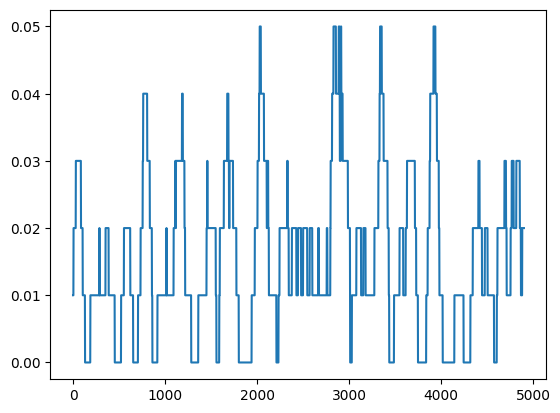

In [24]:
## DO NOT CHANGE THIS CELL
### RANDOM SAMPLING EXAMPLE
init()
num_episodes = 5000   # number of episodes
episode_max_length = 100   # max steps per episode

for i in range(num_episodes):
    # reset environment
    s, info = env.reset()

    for t in range(episode_max_length):
        ################ Random action policy ###########################
        a = env.action_space.sample()

        # step (Gymnasium: 5개 리턴)
        s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        #################################################################

        if done:
            break

# moving average of episode rewards
rm = movingaverage(rList, 100)
plt.plot(rm)


Implement tabular Q-learning (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [27]:
## CHANGE THIS CELL BY YOURSELF
### ALWAYS DO RUN ALL CELLS, otherwise some structures may not get initialized properly

# initialize episodic structure
init()
num_episodes = 5000
episode_max_length = 100

# initialize discount factor, learning rate
gamma = 0.95
learnRate = 0.8

## Epsilon greedy
eps = 0.9
eps_decay = 0.99
##

# Gymnasium에서 seed는 이렇게 설정
env.reset(seed=111)

# create Q table
Q = np.zeros([env.observation_space.n, env.action_space.n])  # matrix Q[s,a]

# execute in episodes
for i in range(num_episodes):

    # reset the environment at the beginning of an episode
    s, info = env.reset()
    s = int(s)   # Discrete state → int 변환
    d = False    # not done

    for t in range(episode_max_length):

        ########### SELECT ACTION a for state s using Q-values ##################
        ##############################################
        # Fill in the e-greedy action
        if np.random.rand() < eps:
          a = env.action_space.sample()
        else:
          a = np.argmax(Q[s])

        ##############################################

        # get new state, reward, done
        s1, r, terminated, truncated, info = env.step(a)
        d = terminated or truncated
        s1 = int(s1)  # Discrete state → int 변환

        ##### update Q(s,a) #########################
        ## Fill in the Q-learning update: Bellman Optimal Equation update
        Q[s][a] = Q[s][a] + learnRate * (r + gamma * np.max(Q[s1]) - Q[s][a])
        #############################################

        # break if done, reached terminal state
        if d:
            break
        s = s1

    eps = eps * eps_decay

plot moving average over 100 episodes

Solved after 643 episodes.


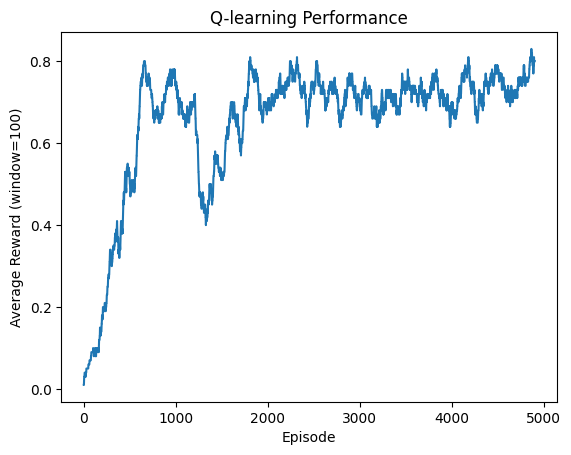

In [28]:
## DO NOT CHANGE THIS CELL
rm = movingaverage(rList, 100)

import matplotlib.pyplot as plt
plt.plot(rm)
plt.xlabel("Episode")
plt.ylabel("Average Reward (window=100)")
plt.title("Q-learning Performance")

criterion = len(np.where(rm >= 0.78)[0]) > 0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= 0.78)[0][0])
else:
    print("Unsolved Yet!")

# Problem 3 (SARSA)
Implement tabular SARSA (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [34]:
num_episodes = 5000
episode_max_length = 100
gamma = 0.95
learn_rate = 0.8
eps = 0.9
eps_decay = 0.99


env.reset(seed=10)
init()

# Q-table 초기화
Q = np.zeros([env.observation_space.n, env.action_space.n])

# 실행
for i in range(num_episodes):
    # Reset the environment at the beginning of an episode
    s, info = env.reset()
    s = int(s)
    done = False

    # 초기 행동 선택 (e-greedy)
    ##############################################
    # Fill in the e-greedy action
    if np.random.rand() < eps:
      a = env.action_space.sample()
    else:
      a = np.argmax(Q[s])

    ##############################################

    for t in range(episode_max_length):

        # Step
        s1, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s1 = int(s1)

        # 다음 행동 선택 (e-greedy)
        ########################################
        # Fill in the e-greedy action
        if np.random.rand() < eps:
          a1 = env.action_space.sample()
        else:
          a1 = np.argmax(Q[s1])

        ########################################

        # SARSA 업데이트
        ###########################################
        # Fill in the SARSA update equation
        Q[s][a] = Q[s][a] + learn_rate * (r + gamma * Q[s1][a1] - Q[s][a])

        ###########################################
        # 종료
        if done:
            break

        # 상태, 행동 업데이트
        s, a = s1, a1

    ########################
    # Epsilon decay
    eps = eps * eps_decay
    ########################

    # Policy improvement
    pi = np.argmax(Q, axis=1)

Solved after 800 episodes.


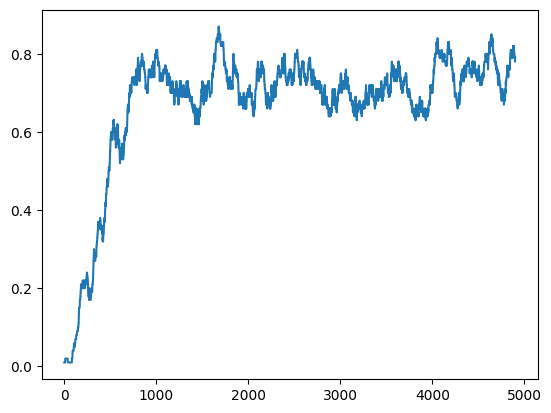

In [35]:
## DO NOT CHANGE THIS CELL
rm = movingaverage(rList, 100)
plt.plot(rm)
criterion = len(np.where(rm >= .78)[0]) > 0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= .78)[0][0])
else:
    print("Unsolved Yet!")